# 7. Интерпретация прогнозов модели (SHAP)

## Набор данных для бинарной классификации

- Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)  
- Сделать обзорный анализ выбранного датасета

Выбран датасет: https://archive.ics.uci.edu/ml/datasets/Adult

**Listing of attributes:**  

>50K, <=50K.

_age:_ continuous.  
_workclass:_ Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
_fnlwgt:_ continuous.  
_education:_ Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.  
_education-num:_ continuous.  
_marital-status:_ Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.  
_occupation:_ Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.  
_relationship:_ Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.  
_race:_ White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.  
_sex:_ Female, Male.  
_capital-gain:_ continuous.  
_capital-loss:_ continuous.  
_hours-per-week:_ continuous.  
_native-country:_ United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

**Задача:** Спрогнозировать, превышает ли доход 50 тысяч в год на основе данных переписи.

In [1]:
import numpy as np
import pandas as pd
import itertools
import shap

# load JS visualization code to notebook
shap.initjs()

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import catboost as catb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, \
                            precision_recall_curve, confusion_matrix, log_loss

import warnings
warnings.simplefilter("ignore")

In [2]:
# Группировка признаков по типам
def group_features(df, TARGET='target'):
    try: BASE_FEATURE = df.columns.drop(TARGET).tolist()
    except: BASE_FEATURE = df.columns.tolist()
    CAT_FEATURE = df[BASE_FEATURE].select_dtypes(include='object').columns.tolist()
    NUM_FEATURE = df[BASE_FEATURE].columns.drop(CAT_FEATURE).tolist()
    return TARGET, BASE_FEATURE, NUM_FEATURE, CAT_FEATURE

# Перевод категориальных признаков в dummies
def dummies_col(df, colgroup):
    for colname in colgroup:
        df = pd.concat([df, pd.get_dummies(df[colname], prefix=colname)], axis=1)
    return df

# Удаление столбцов
def drop_col(df, colgroup):
    for column in colgroup:
        df = df.drop(column, axis=1)  
    return df

In [3]:
# Расчет метрик
def get_metrics(y_valid, preds, matrix=True):
    
    precision, recall, thresholds = precision_recall_curve(y_valid, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = round(roc_auc_score(y_valid, preds), 3)
    logloss = round(log_loss(y_valid, preds), 3)

    ix = np.argmax(fscore)
    if matrix == True:
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f, log-loss=%.3F' % (
                        thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss))
    
        plt.figure(figsize=(8, 6))
        font = {'size' : 12}
        plt.rc('font', **font)

        cnf_matrix = confusion_matrix(y_valid, preds>thresholds[ix])
        plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
        plt.show()
    else:
        return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss

# Матрица ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Загрузка и обзор данных:**

In [4]:
df = pd.read_csv('data/adult.csv', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.shape

(32561, 15)

In [6]:
# Переименуем признаки для удобства
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', \
               'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'target']

In [7]:
df['target'].unique()

array(['<=50K', '>50K'], dtype=object)

In [8]:
# Заменим '<=50K', '>50K' на числа
df['target'] = list(map(lambda x: 0 if x=='<=50K' else 1, df['target']))
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [9]:
df['target'].value_counts()

0    24720
1     7841
Name: target, dtype: int64

## Feature Engineering

Сделать feature engineering.

In [10]:
TARGET, BASE_FEATURE, NUM_FEATURE, CAT_FEATURE = group_features(df)

In [11]:
NUM_FEATURE

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [12]:
CAT_FEATURE

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [13]:
# Переведем категориальные признаки в dummies
df = dummies_col(df, CAT_FEATURE)

In [14]:
# Удалим признаки в старом формате
df = drop_col(df, CAT_FEATURE)

In [15]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,...,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810,0.056386,0.029483,0.064279,...,0.001136,0.003501,0.000369,0.002457,0.001566,0.000553,0.000584,0.895857,0.002058,0.000491
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581,0.230670,0.169159,0.245254,...,0.033691,0.059068,0.019194,0.049507,0.039546,0.023506,0.024149,0.305451,0.045316,0.022162
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
print('Количество уникальных значений всех признаков:')
for i in df.columns:
    print(f'{i} - {df[i].nunique()}')

Количество уникальных значений всех признаков:
age - 73
fnlwgt - 21648
education-num - 16
capital-gain - 119
capital-loss - 92
hours-per-week - 94
target - 2
workclass_? - 2
workclass_Federal-gov - 2
workclass_Local-gov - 2
workclass_Never-worked - 2
workclass_Private - 2
workclass_Self-emp-inc - 2
workclass_Self-emp-not-inc - 2
workclass_State-gov - 2
workclass_Without-pay - 2
education_10th - 2
education_11th - 2
education_12th - 2
education_1st-4th - 2
education_5th-6th - 2
education_7th-8th - 2
education_9th - 2
education_Assoc-acdm - 2
education_Assoc-voc - 2
education_Bachelors - 2
education_Doctorate - 2
education_HS-grad - 2
education_Masters - 2
education_Preschool - 2
education_Prof-school - 2
education_Some-college - 2
marital-status_Divorced - 2
marital-status_Married-AF-spouse - 2
marital-status_Married-civ-spouse - 2
marital-status_Married-spouse-absent - 2
marital-status_Never-married - 2
marital-status_Separated - 2
marital-status_Widowed - 2
occupation_? - 2
occupation

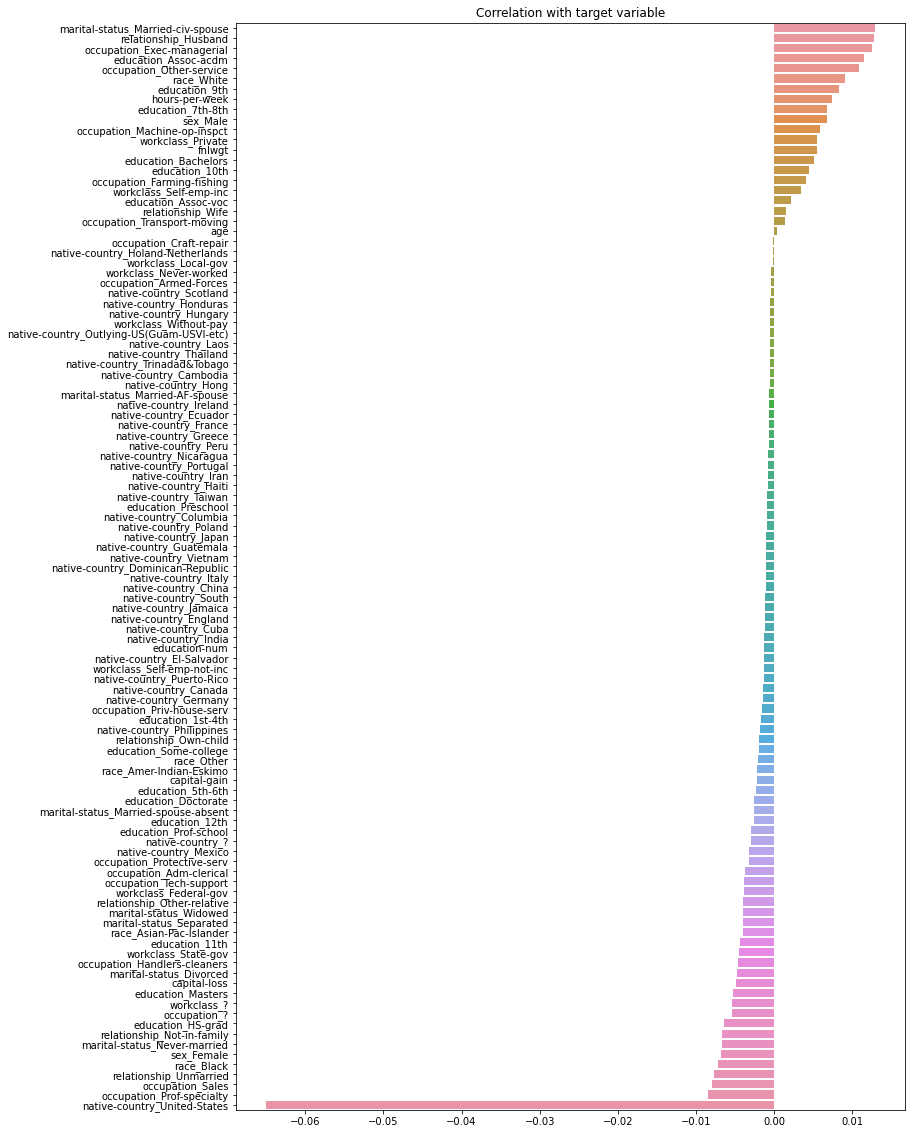

In [17]:
# Посмотрим зависимость признаков
corr_with_target = df.drop('target', axis=1).corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(12, 20))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

## Обучение модели

Обучить любой классификатор (какой вам нравится).

In [18]:
# Разделяем набор признаков
X = df.drop('target', axis=1)
y = df['target']

# Разбиваем выборку на трейн и на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

# Выводим результат разбиения
X_train.shape, X_test.shape

((22792, 108), (9769, 108))

In [19]:
# Рассчитываем величину дисбаланса
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance = round(disbalance, 2)
disbalance

3.15

In [20]:
# Обучаем модель
model = catb.CatBoostClassifier(silent=True, 
                                     random_state=21, 
                                     class_weights=[1, disbalance],
                                     max_depth=4
                                    )

model.fit(X_train, y_train)
preds = model.predict_proba(X_test)[:, 1:]

Best Threshold=0.686779, F-Score=0.729, Precision=0.741, Recall=0.718, Roc-AUC=0.926, log-loss=0.340
Confusion matrix, without normalization
[[6828  589]
 [ 665 1687]]


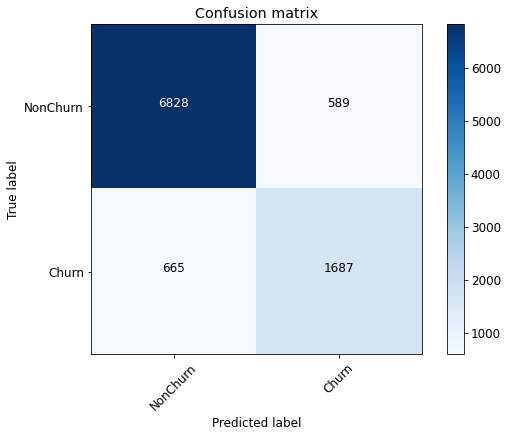

In [21]:
# Посчитаем метрики
get_metrics(y_test, preds, matrix=True)

## Важность признаков (SHAP)

Разобраться с SHAP и построить важности признаков для:  
- всего тестового набора данных (summary_plot - дать интерпретацию)  
- для топ 10% (сортировка по убыванию вероятности - таргета)

In [22]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

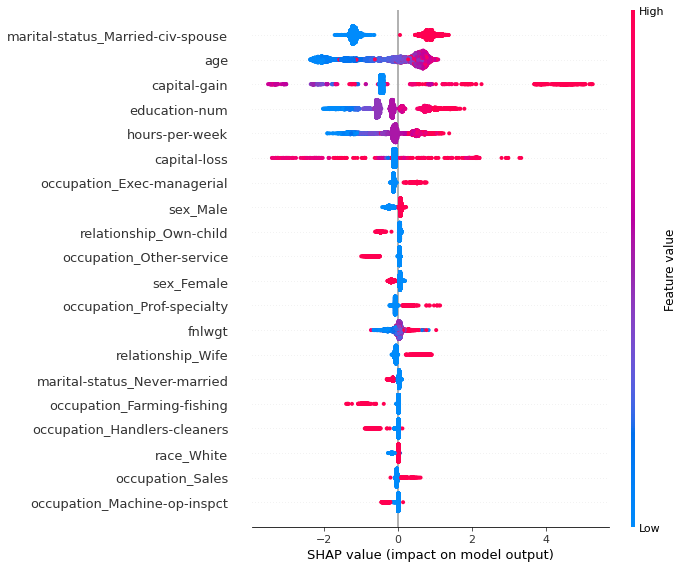

In [23]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

**Интерпретация:**  
На вероятность преодоления порога по заработку свыше 50К влияют следующие признаки:   

**marital-status_Married-civ-spouse:** состоит в браке, без этого денег не дают :)  
**age:** опыт приходит с годами, чем старше, тем заработок больше  
**capital-gain:** постоянный доход влияет на ситуацию как нельзя лучше  
**education-num:** разумеется без образования никуда - чем оно круче, тем доход выше  
**hours-per-week:** чем больше часов в неделю работаем, тем больше зарабатываем  
**capital-loss:** тут что-то странное получается... связанное с потерей дохода  
**occupation_Exec-managerial:** быть управляющим или исполнительным директором весьма выгодно :)  
**sex_Male, sex_Famale:** и да... еще нужно быть мужчиной, чтобы зарабатывать больше :)  
**relationship_Own-child:** ужасно, но нужно иметь плохие отношения с собственным ребенком  
**occupation_Other-service:** не заниматься оказанием непонятных услуг :)  
**occupation_Prof-specialty:** иметь профессиональное образование, специальность  
**fnlwgt:** непрерывный стаж работы  
**relationship_Wife:** нужно обязательно иметь жену :)   
**marital-status_Never-married:** да и еще раз да, быть холостяком совсем не выгодно  
**occupation_Farming-fishing:** ходить на рыбалку, как оказыватся тоже  
**occupation_Handlers-cleaners:** нельзя быть уборщиком, до добра это не доведет  
**race_White:** цвет кожи на наличие хрустящих купюр в кармане почти не влияет :)  
**occupation_Sales:** и кстати быть продажником вполне себе выгодно  
**occupation_Machine-op-inspct:** а вот быть техническим инспектором довольно сомнительное занятие

In [24]:
target = pd.DataFrame(y_test, columns=['target'], index=X_test.index)
target.head()

,target
2725,1
9814,1
951,1
370,0
32400,1


In [25]:
test_data = pd.concat([X_test, target], 1)
test_data.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,target
2725,28,355259,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9814,45,188950,14,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
951,43,227065,14,0,0,43,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
370,26,185885,10,0,0,15,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
32400,53,186303,10,0,1887,40,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [26]:
display(X_test.shape, y_test.shape)

(9769, 108)

(9769,)

In [27]:
top10 = test_data.sort_values(by=['target'], ascending=False).head(970).drop(['target'], axis=1)
top10

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
2725,28,355259,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11897,47,191277,10,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
25850,45,348172,13,7298,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
28139,54,172281,14,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
26488,31,162442,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15767,35,81232,13,15024,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5224,51,193720,13,0,0,45,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
11847,35,45607,14,0,0,60,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1771,50,171338,10,99999,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [28]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer_10 = shap.TreeExplainer(model)
shap_values_10 = explainer_10.shap_values(top10)

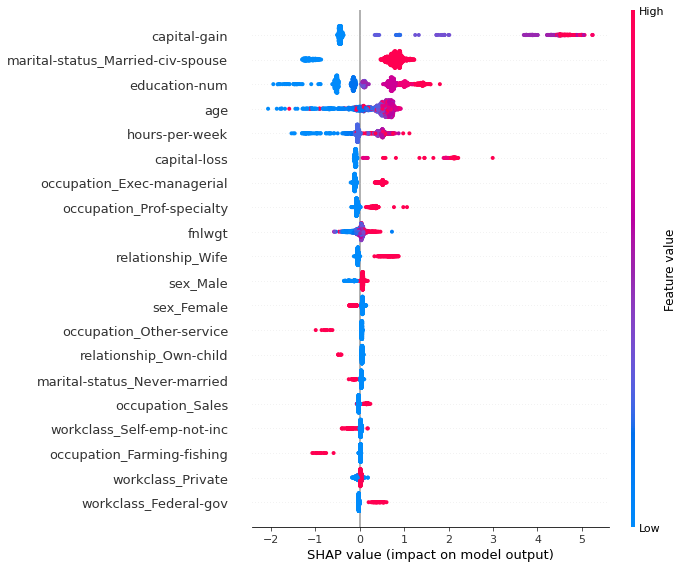

In [29]:
# summarize the effects of all the features
shap.summary_plot(shap_values_10, top10)

**Интерпретация:**  
На вероятность преодоления порога по заработку свыше 50К влияют следующие признаки:   

**capital-gain:** постоянный доход по прежнему положительно влияет на ситуацию  
**marital-status_Married-civ-spouse:** все также нужно состоять в браке, без этого денег не дают :)  
**education-num:** как обычно без образования никуда - чем оно круче, тем доход выше  
**age:** опыт приходит с годами, чем старше, тем заработок больше  
**hours-per-week:** чем больше часов в неделю работаем, тем больше зарабатываем  
**capital-loss:** ммм... банкротство влияет на увеличение дохода?! :)  
**occupation_Exec-managerial:** быть управляющим или исполнительным директором по-прежнему выгодно :)  
**occupation_Prof-specialty:** иметь профессиональное образование, специальность  
**fnlwgt:** непрерывный стаж работы  
**relationship_Wife:** нужно обязательно иметь жену :)  
**sex_Male, sex_Famale:** и да... еще нужно быть мужчиной, чтобы зарабатывать больше :)  
**occupation_Other-service:** не заниматься оказанием непонятных услуг :)  
**relationship_Own-child:** по-прежнему иметь плохие отношения с собственным ребенком  
**marital-status_Never-married:** да и еще раз да, быть холостяком совсем не выгодно  
**occupation_Sales:** и кстати быть продажником вполне себе выгодно  
**workclass_Self-emp-not-inc:** и вот новенькое - нужно подальше держаться от рабочего класса :)  
**occupation_Farming-fishing:** и еще не ходить на рыбалку :)  
**workclass_Federal-gov:** работа на правительство вещь сомнительная :)  
**workclass_Private:** а вот быть предпринимателем это не просто почетно, но и выгодно!  

## force_plot

Для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат.

In [30]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

In [31]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer_10.expected_value, shap_values_10[0,:], top10.iloc[0,:])

**Интерпретация:**  
Базовое значение -0.16, видимо вероятность зарабатывать более 50К совсем невысокая.  